<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/Milestone_Project_SkimLit_NLP_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📃🔥

The purpose of this notebook is to build NLP model to make reading medical abstracts easier.

> The paper we're replicating (source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071


> And reading through the paper above, we see that model architecture that the y use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Confirm access to a GPU

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4669ab09-5432-ccfc-b827-7de43507f26a)


## Get Data

Since we'll be replicating the paper above (PubMed 200k RCT dataset) let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 37.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [5]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


🔑 **Note:** dev is also known as validation set in the world of Machine Learning.

In [6]:
# Start our experiments using the 20k dataset with numbers replaced with at_sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, Visualzie, Visualzie
So with that in mind, let's write a function to read in all of the lines of a target file.

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  '''
  Reads filename (a text filename) and returns the lines of text as a list.
  Args:
    filename: a string containing the target filepath

  Return:
    A list of strings with one string per line from the target filename.
  '''

  with open(filename, 'r') as f:
    return f.readlines()

In [9]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20] # the whole first example of the training data

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

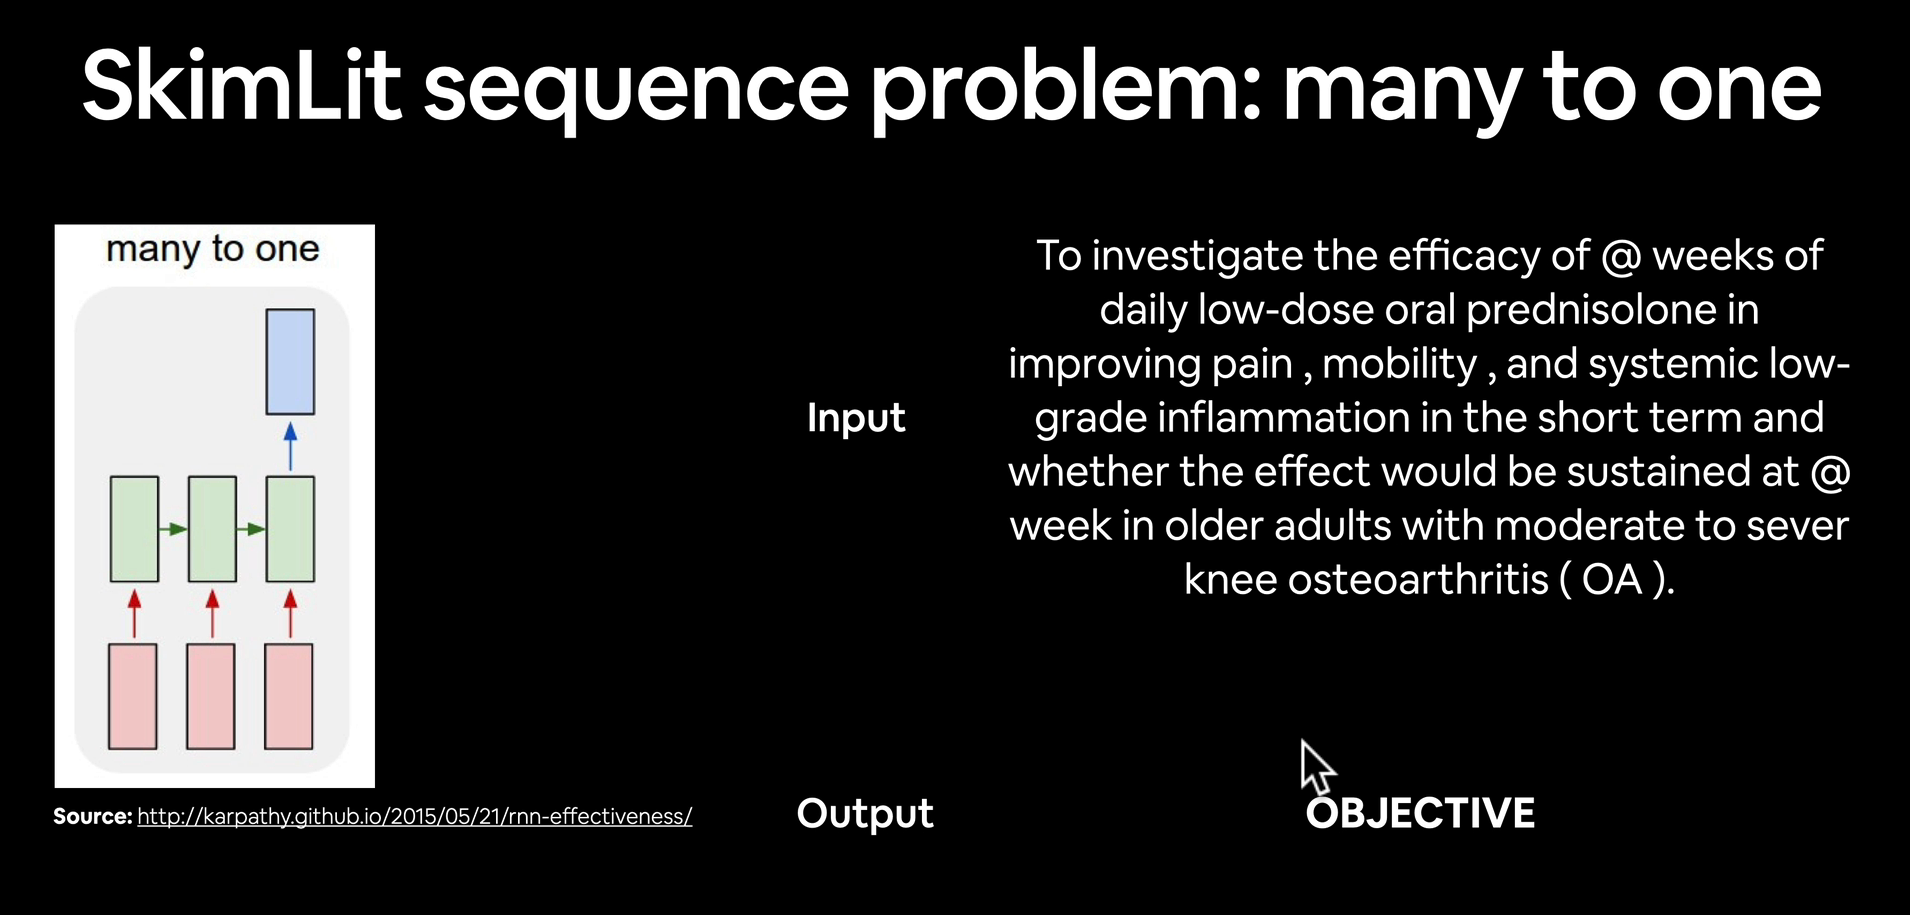

In [10]:
len(train_lines)

210040

Think about how you want your data to look...

How I think our data would be best represented...

```
[{'line number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11}]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [17]:
def preprocess_text_data(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  '''

  input_lines = get_lines(filename)  # get all lines from filename
  abstract_lines = ""  # create an empty abstract
  abstract_samples = []  # empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:

    if line.startswith("###"):  # if line is an ID line
      abstract_id = line
      abstract_lines = ""  # reset abstract string

    elif line.isspace():  # if line is a new line
      abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):  # return current abstract_line_number

        line_data = {}  # create empty dict to store data from line

        line_data['line number'] = abstract_line_number  # get current line number
        line_data['target'] = abstract_line.split("\t")[0]  # get label from line
        line_data['text'] = abstract_line.split('\t')[1].lower()  # get current line
        line_data['total_lines'] = len(abstract_line_split) - 1  # get total lines in abstract

        abstract_samples.append(line_data)  # add line data to abstract samples list

    else:
      abstract_lines += line  # append abstract line to string

  return abstract_samples


In [18]:
preprocess_text_data(data_dir + "train.txt")

[{'line number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [21]:
# Get the data from file and preprocess it
%%time
train_samples = preprocess_text_data(data_dir + "train.txt")
dev_samples = preprocess_text_data(data_dir + "dev.txt")
test_samples = preprocess_text_data(data_dir + "test.txt")

len(train_samples), len(dev_samples), len(test_samples)

CPU times: user 432 ms, sys: 20 ms, total: 452 ms
Wall time: 452 ms


(180040, 30212, 30135)

In [25]:
# Check the first 10 abstract samples of our training data
train_samples[:13]

[{'line number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, let's turn them into a dataframe

In [26]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
dev_df = pd.DataFrame(dev_samples)
test_df = pd.DataFrame(test_samples)

In [28]:
train_df.head(13)

,line number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [31]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

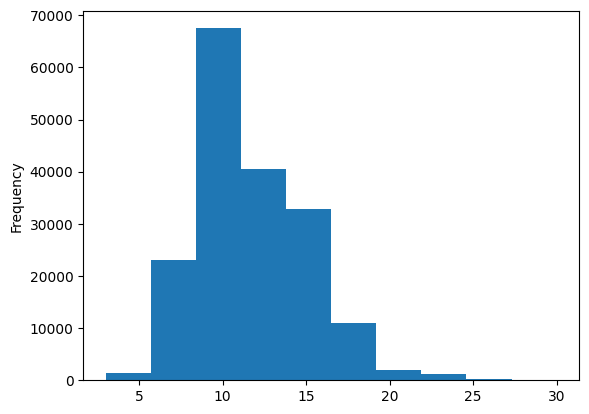

In [32]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [33]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
dev_sentences = dev_df.text.tolist()
test_sentences = test_df.text.tolist()
len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

In [34]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Turning our target labels into numbers

In [51]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)  # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))  # We want non-sparse matrix

# check what one hot encoded labels look like
train_labels_one_hot.shape, dev_labels_one_hot.shape, test_labels_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

### Label encode labels

In [53]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
dev_labels_encoded = label_encoder.transform(dev_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what label integers look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [54]:
# Get class names and number of classes from labelEncoder isntance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments we're running
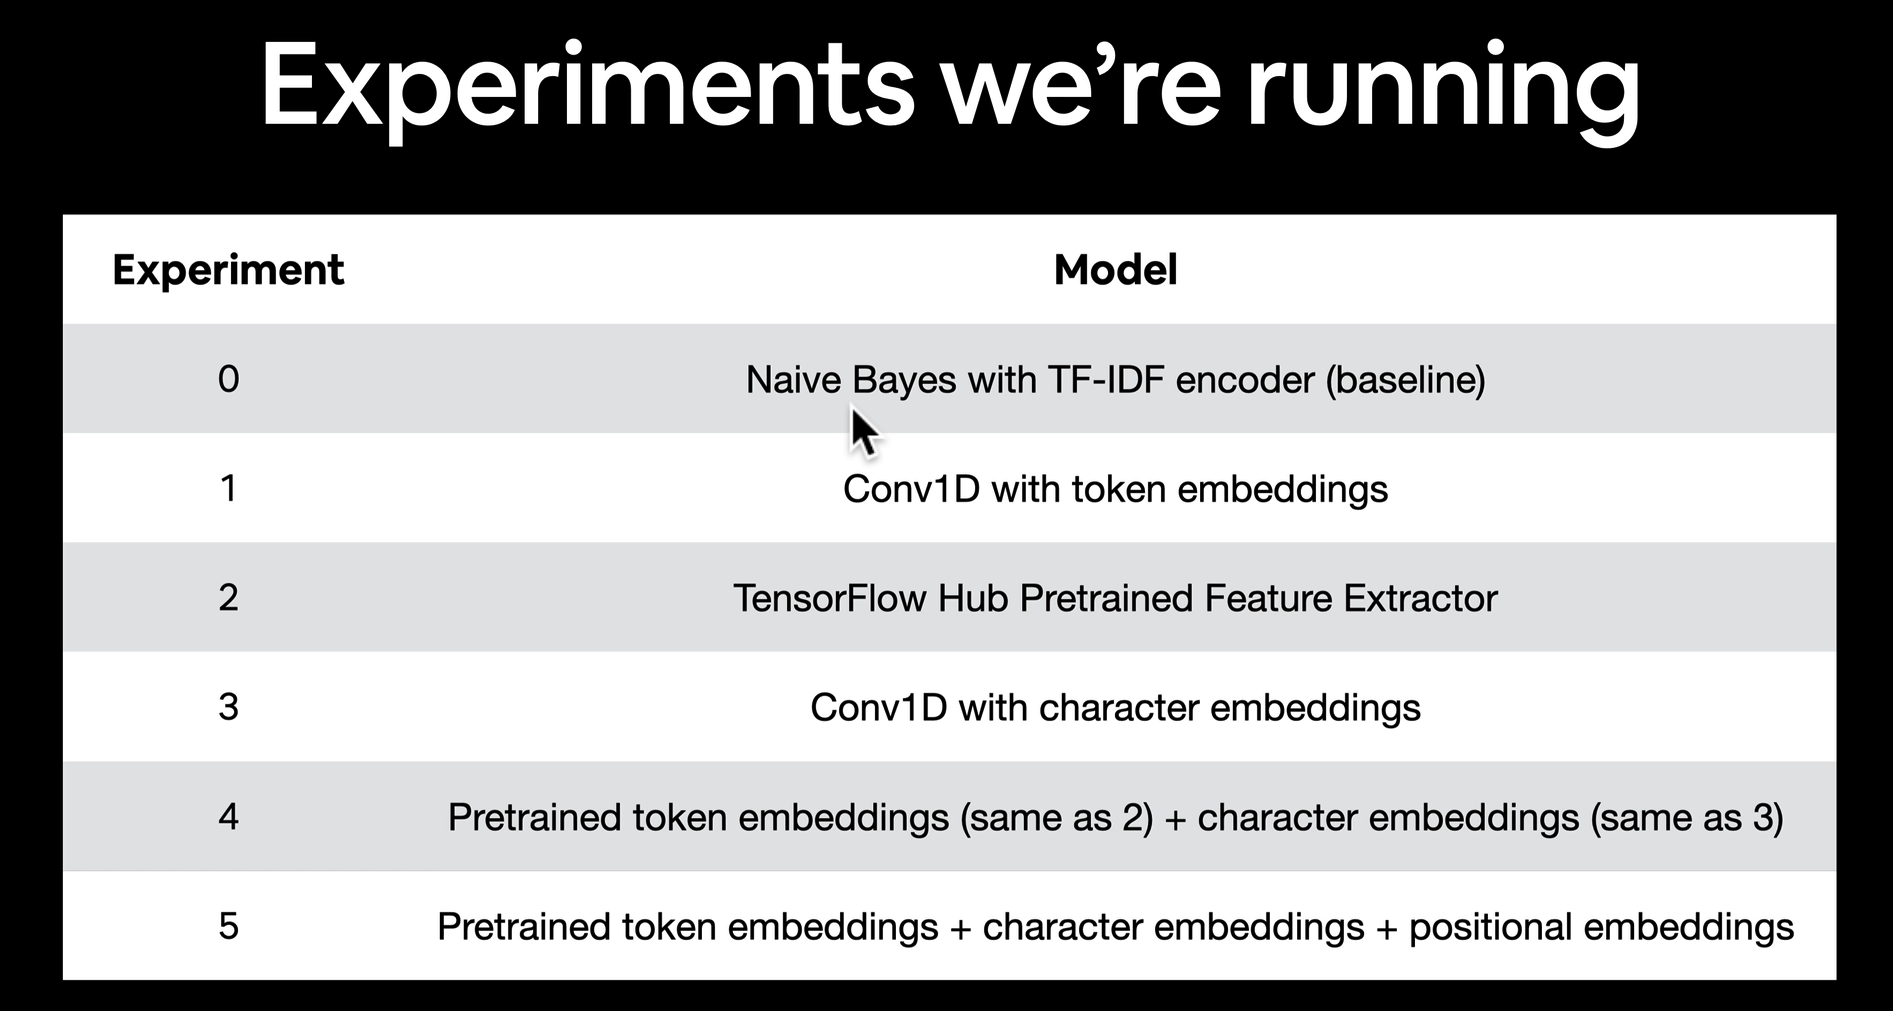

## Starting a series of modelling experiments...

As usual, we're going to be trying bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial classifier)

Checkout Chris Albon

### Model 0: Naive Bayes with TF-IDF encoder (baseline)

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [67]:
# Evaluate baseline model on validation dataset
model_0.score(X=dev_sentences, y=dev_labels_encoded)

0.7218323844829869

What happens in the backend (Pipeline)

In [62]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(train_sentences)
# X_train_counts.shape

In [63]:
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_train_tfidf.shape

In [64]:
# from sklearn.naive_bayes import MultinomialNB
# clf = MultinomialNB().fit(X_train_tfidf, train_labels_encoded);

In [65]:
# dev_sentences_counts = count_vect.transform(dev_sentences)
# dev_sentences_tfidf = tfidf_transformer.transform(dev_sentences_counts)

# clf.score(dev_sentences_tfidf, dev_labels_encoded)

In [68]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(dev_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

### Download the helper functions script

In the previous module, we wrote to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script

In [69]:
# Download the script
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py

--2024-04-03 10:46:49--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16634 (16K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.24K  --.-KB/s    in 0.001s  

2024-04-03 10:46:49 (26.3 MB/s) - ‘helper.py’ saved [16634/16634]



In [70]:
from helper import *

In [71]:
model_0_results = ModelEvaluation.results(y_true=dev_labels_encoded,
                                          y_pred=baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

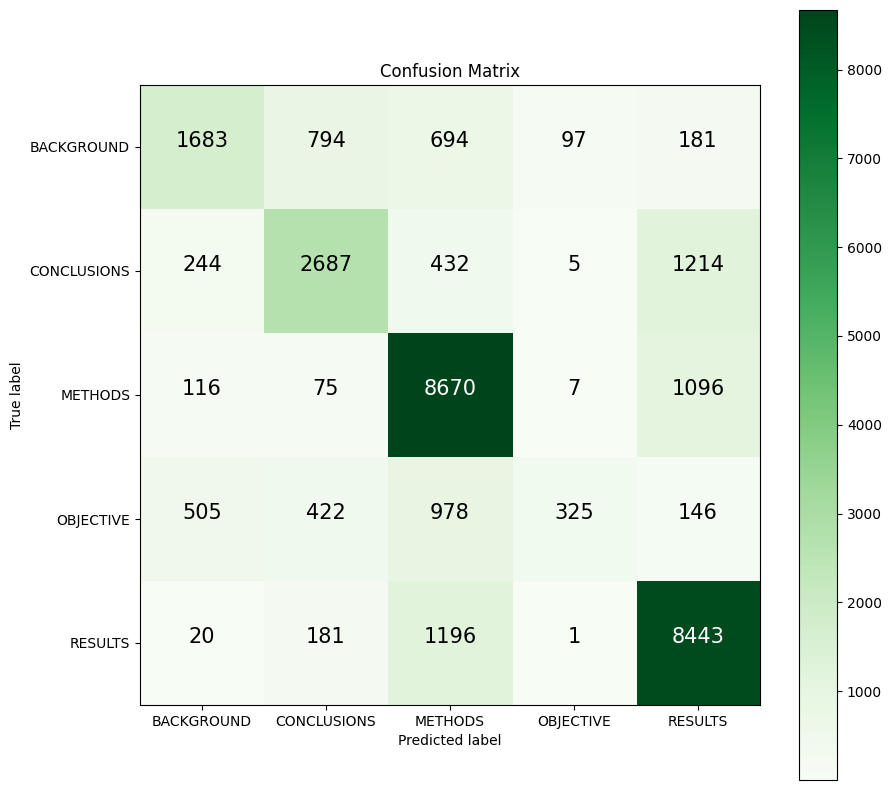

In [74]:
# Visualize the predictions
ModelEvaluation.make_confusion_matrix(y_true=dev_labels_encoded,
                               y_pred=baseline_preds,
                               classes=list(class_names))